# パターン認識問題を解いてみる

## パターン識別編（ロジスティック回帰による解法）

それでは手書き文字データセット MNIST の識別を行ってみましょう.
外部と通信してデータをとってきます．

解説付きでコードを示しています．使い方としては

1. 上から順に読んで（重要），
2. セルを実行していってください．
3. 理解できない場合は，スタッフに質問を投げるなどしてください．
4. 理解が進んだら，自分のノートを作成し，ページにコードを真似して記述していってください．

In [1]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist

MNIST のデータセットの読み込みを `tensorflow.keras.datasets.mnist.load_data()` で行うと，学習用の文字データとラベル，テスト用の文字データとラベルが帰ってくる

In [2]:
# データセットの読み込み
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 数値データは 28 x 28 の画素からなり， 画素値は　[0, 255] の数値．　画素値が大きいと取り扱いにくいので，全部 [0, 1] へ標準化

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #画像輝度値は [0, 255] で定義されるので，[0, 1] になるようにスケーリング
x_test /= 255  #同上

11501568/11490434 [==============================] - 0s 0us/step


### これで下準備完了

(x_train, y_train) にデータが入っていて，(x_test, y_test) に評価用のデータが入っている

ためしにデータを表示させt見る

label =  5


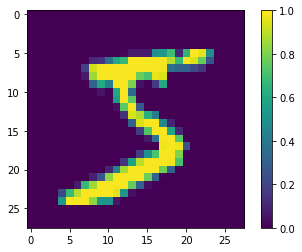

In [3]:
# 試しに　 x_train の０番目の文字を表示させてみる

plt.imshow(x_train[0])
print('label = ', y_train[0])
plt.colorbar()

データの次元が 28 x 28 だが，次元が大きくなっただけで
ロジスティック回帰は使えるので試してみる．

$f(x; w) = \sigma( w_1 x + w_0)$ の $w_1$ がベクトルになり $w_1 x$ の演算が内積になるのは２変数のときと一緒．


大きく変わるのは，分類が１０クラス分類になるところで，
この場合は，活性化関数には 'softmax' を使うところが異なります．

このような多クラス分類で `softmax` をロス関数として使う場合，ロス関数も
`binary_crossentropy` を拡張した `categorical_crossentropy` を使う．
ここらへんの理屈は知りたい人は質問してください．

最適化プロセスの本質部分である

### モデル $f(x_n; w)$ とラベルとのロスが小さくなるように $w$ を求める．

という部分は変わりません．

## Keras + TensorFlow を用いた解法

結構計算時間かかります．

In [4]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical

In [5]:
# ラベルデータを tensorflow の形式に合致するよう変換 

# データは， 28x 28 =784 次元で，２次元配列の形をしている意味は今はないので，
# reshape で１次元になおしてしまおう

input_shape = 28 * 28
x_train = x_train.reshape(60000, input_shape)
x_test = x_test.reshape(10000, input_shape)

# 他クラス分類ように y をカテゴリカルな one-hot-vector に変換．
# 10個の変数の所定位置にフラグを立てて変数値を表すやりかた．
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# print(y_train[0].shape) # 形状を確認するのは重要

In [6]:
# モデルの構築は今までと一緒

model = Sequential()   # 階層型のモデルを選択
model.add(Dense(num_classes, input_shape=(input_shape,), use_bias=True)) # 入力がinput_shape, 出力が num_classes 個
model.add(Activation('softmax')) # 多クラス分類の場合は活性化関数を softmax へ変更する必要がある

model.compile(loss='categorical_crossentropy',  optimizer='adam') #最適化手法を指定

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 学習によるパラメータフィット(時間かかります)
hist = model.fit(x_train, y_train, epochs=80, batch_size=8192, verbose=0)

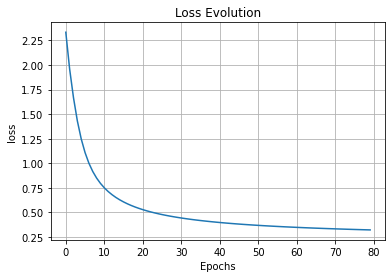

In [8]:
# ロスの値が学習によってどう変わるかを表示

plt.plot(hist.history['loss'])
#plt.semilogy(hist.history['loss'])
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

かなり頑張って収束しているぽい．
とりあえず，いくつかのテストサンプルで予測してみる

予測は，1-hot vector 表現として出てくる
クラス番号をしりたい

True label 7
Estimate label 7


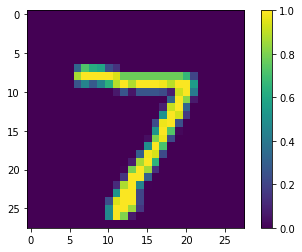

In [9]:
p = 0   # パターン番号（ここを適当に変えると別のパターンをテストできる

# print('真値の 1-hot-vector 表現', y_test[p])
print('True label', np.argmax(y_test[p]))
print('Estimate label', np.argmax(model.predict(x_test[p:p+1])))

plt.imshow(x_test[p].reshape(28, 28))
plt.colorbar()

じゃ，統計を採ってみよう

In [10]:
#y_predict = model.predict_classes(x_test)  #predict_classes が deprecated なので変更
y_predict = np.argmax(model.predict(x_test), axis=-1)

# テストのラベルは 1-hot-vector になっているので 差分をとる
residual = to_categorical(y_predict) - y_test

# 各行を見てって，すべてが０であれば，正しく予測できているが，
# そうでない場合は間違っている．
# とりあえず，間違いの個数をピックアップ

errnum = residual.max(axis=1).sum()

# １0000 個中の間違い個数の割合がご識別率
print( "Error rate = %.3f" % (errnum / 10000))

Error rate = 0.084


１割弱は間違い，適当に作ってる割には，まぁまぁの成績かな